# Compresión de Imágenes con SVD

## Carga de la imágen

In [1]:
from matplotlib.image import imread
from matplotlib.image import imsave
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import time

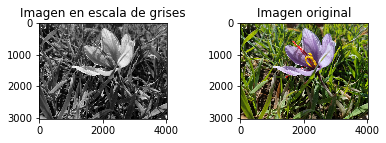

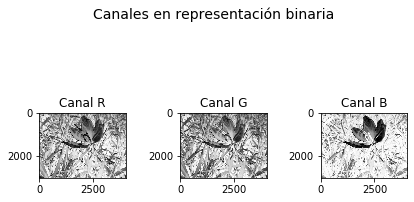

In [2]:
file = 'saffron_1.jpg'
img_orig = imread(file) 
A_r = img_orig[:, :, 0] # Canal R de la imagen
A_g = img_orig[:, :, 1] # Canal G de la imagen
A_b = img_orig[:, :, 2] # Canal B de la imagen
A=np.mean(img_orig,-1); 

fig, ax = plt.subplots(1, 2)
axis = ax.flat
axis[0].imshow(A, cmap='gray')
axis[1].imshow(img_orig)
axis[0].set_title('Imagen en escala de grises')
axis[1].set_title('Imagen original')
plt.tight_layout(pad=3.0)
plt.show()

fig_1, ax_1 = plt.subplots(1, 3)
plt.suptitle("Canales en representación binaria", fontsize=14)
axis_1 = ax_1.flat
axis_1[0].imshow(A_r, cmap='binary')
axis_1[1].imshow(A_g, cmap='binary')
axis_1[2].imshow(A_b, cmap='binary')
axis_1[0].set_title('Canal R')
axis_1[1].set_title('Canal G')
axis_1[2].set_title('Canal B')
plt.tight_layout(True)
plt.show()

# Se guardan la imagen en escala de grises y la de cada uno de los canales para comparación de reducción de espacio

# Guardar la imagen original en escala de grises 
file_gray=os.path.splitext(file)[0]+'_grey'+os.path.splitext(file)[1]
imsave(file_gray,A,cmap="gray")

file_red=os.path.splitext(file)[0]+'_red'+os.path.splitext(file)[1]
imsave(file_red,A_r,cmap="gray")

file_green=os.path.splitext(file)[0]+'_green'+os.path.splitext(file)[1] 
imsave(file_green,A_g,cmap="gray")

file_blue=os.path.splitext(file)[0]+'_blue'+os.path.splitext(file)[1]
imsave(file_blue,A_b,cmap="gray")



## Implementación de SVD en CPU

In [3]:
cpu_start = time.time()
U, S, VT=np.linalg.svd(A)
cpu_end = time.time()
print("Tiempo de ejecución cpu: {} sec".format(np.round(cpu_end-cpu_start,2)))
S=np.diag(S)

Tiempo de ejecución cpu: 16.62 sec


## Implementación de SVD en GPU con PyTorch

In [5]:
device = torch.device("cuda") 
A_tensor = torch.from_numpy(A)
A_cuda = A_tensor.to(device)
cuda_start = time.time()
U_cuda, S_cuda, V_cuda = torch.svd(A_cuda)
cuda_end = time.time()
print("Tiempo de ejecución gpu: {} sec".format(np.round(cuda_end - cuda_start,2)))
U_cuda = U_cuda.cpu().numpy()
S_cuda = S_cuda.cpu().numpy()
V_cuda = V_cuda.cpu().numpy()
S_cuda=np.diag(S_cuda)
time_red = (1-(cuda_end-cuda_start)/(cpu_end-cpu_start))*100 
print("Reducción de tiempo de ejecución: {}%".format(np.round(time_red,2)))

Tiempo de ejecución gpu: 19.05 sec
Reducción de tiempo de ejecución: -14.61%


In [6]:
def gpu_svd(A):
    A_aux = A
    A_tensor = torch.from_numpy(A_aux)
    A_cuda = A_tensor.to(device)
    U_cuda, S_cuda, V_cuda = torch.svd(A_cuda)
    U_cuda = U_cuda.cpu().numpy()
    S_cuda = S_cuda.cpu().numpy()
    V_cuda = V_cuda.cpu().numpy()
    S_cuda=np.diag(S_cuda)
    return U_cuda, S_cuda, V_cuda

## Compresión

In [7]:
def compresion(k, U, S, VT):
    return U[:,:k] @ S[0:k,:k] @ VT[:k,:]

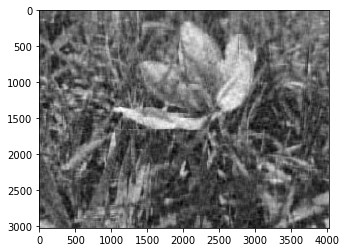

In [30]:
# Ejemplo para un número k de valores singulares determinado
k=30;
A_k = compresion(k, U, S, VT)
img=plt.imshow(A_k)
img.set_cmap('gray')
plt.show()

## Métricas

In [9]:
# Espacio reducido de archivo ss (saved space)
def saved_space(orig_path, A_k):
    file_k = os.path.splitext(orig_path)[0]+'_k'+os.path.splitext(orig_path)[1] 
    imsave(file_k,A_k,cmap="gray")
    sizeOrig=os.stat(orig_path).st_size;
    sizeRed=os.stat(file_k).st_size;
    return (sizeOrig-sizeRed)/sizeOrig; # Porcentaje de reducción.

In [10]:
print("Porcentaje de reducción: {0:.2f}%".format(saved_space(file_gray, A_k)*100))

Porcentaje de reducción: 44.36%


In [11]:
# Compression Rate (CR)
def compression_rate(A_orig, k):
    n = A_orig.shape[0]
    m = A_orig.shape[1]
    return (n*m)/(k*(n+m+1))

In [12]:
print("Compression Rate (CR): {0:.2f}".format(compression_rate(A, k)))

Compression Rate (CR): 57.59


In [13]:
# Energy Truncation
def energy_truncation(A, A_k):
    return np.linalg.norm(A_k)/np.linalg.norm(A)

In [14]:
# Error truncation (Frobenius)
def error_truncation(A, A_k):
    return np.linalg.norm(A-A_k)/np.linalg.norm(A)

In [15]:
print("Error de truncado basado en Frobenius: {0:.2f}%".format(error_truncation(A, A_k)*100))


Error de truncado basado en Frobenius: 21.69%


## K en función de métricas

In [16]:
# K en función del espacio comprimido (ss) deseado

def saved_space_compression(ss_sel, U, S, VT, path):
    k=1
    ss=1
    while (ss>ss_sel):
        A_k = compresion(k, U, S, VT)
        ss = saved_space(path, A_k)
        k = k + 1
    return ss, k-1

In [17]:
ss, k_40 = saved_space_compression(0.4, U, S, VT, file_gray)
print("Rango k:{}".format(k_40))
print("Reducción de Espacio:{0:.2f}%".format(ss*100))

Rango k:47
Reducción de Espacio:39.82%


In [18]:
# K en función del error de truncado deseado
def error_truncation_compression(A, et_sel, U, S, VT):
    k=1
    et=1
    while (et>et_sel):
        A_k = compresion(k, U, S, VT)
        et = error_truncation(A, A_k)
        k=k+1
    return et, k-1

In [19]:
et, k_10 = error_truncation_compression(A, 0.1, U, S, VT)
print("Rango k:{}".format(k_10))
print("Error de truncado relativo:{0:.2f}%".format(et*100))

Rango k:101
Error de truncado relativo:10.00%


## Características Valores Singulares

Principales valores singulares: 


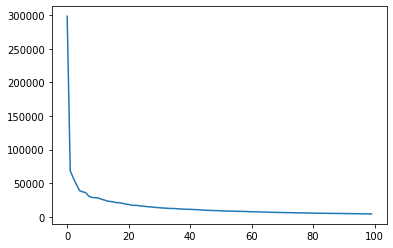

In [20]:
print("Principales valores singulares: ")
s_values = np.diagonal(S)
s_index = np.arange(S.shape[0])
plt.figure(2)
plt.plot(s_index[0:100], s_values[0:100])
plt.show()

Razón de cambio de los valores singulares respecto del índice. Calculados por diferencia central


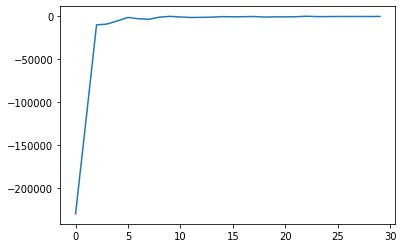

In [21]:
print("Razón de cambio de los valores singulares respecto del índice. Calculados por diferencia central")
s_grad = np.gradient(s_values)
plt.figure(3)
plt.plot(s_index[0:30], s_grad[0:30])
plt.show()

## Evolución de métricas en función de k

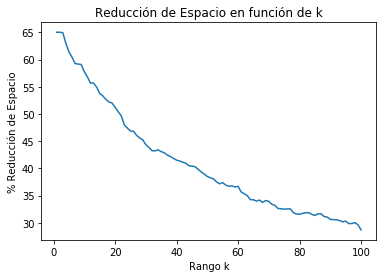

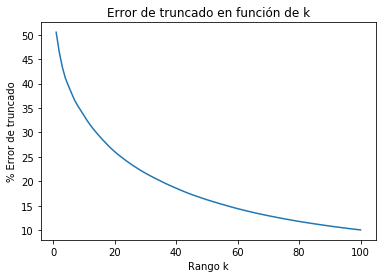

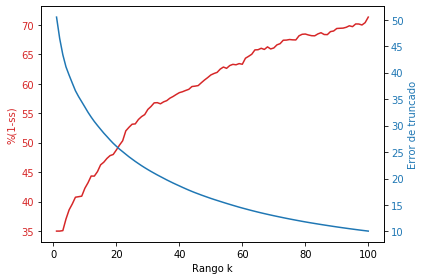

In [22]:
# Variación del espacio reducido (ss) y el error de truncado en función del rango k (1-100)
max_k = 100
ss_k = []
et_k = []
idx = np.arange(max_k)+1
for k in range(max_k):
    A_k = compresion(k+1, U, S, VT)
    ss_k.append(saved_space(file_gray, A_k))
    et_k.append(error_truncation(A, A_k))

ss_k = np.array(ss_k)
et_k = np.array(et_k)
et_k = et_k*100
ss_k = ss_k*100

plt.figure(1)
plt.plot(idx, ss_k)
plt.xlabel("Rango k")
plt.ylabel("% Reducción de Espacio")
plt.title("Reducción de Espacio en función de k")
plt.show()

plt.figure(2)
plt.plot(idx, et_k)
plt.xlabel("Rango k")
plt.ylabel("% Error de truncado")
plt.title("Error de truncado en función de k")
plt.show()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Rango k')
ax1.set_ylabel('%(1-ss)', color=color)
ax1.plot(idx, 100-ss_k, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Error de truncado', color=color)  
ax2.plot(idx, et_k, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()


## Pruebas con reducción en canales

In [23]:
# Calculo de la SVD de cada uno de los canales
U_r, S_r, VT_r=np.linalg.svd(A_r)
U_g, S_g, VT_g=np.linalg.svd(A_g)
U_b, S_b, VT_b=np.linalg.svd(A_b)
S_r=np.diag(S_r)
S_g=np.diag(S_g)
S_b=np.diag(S_b)


In [24]:
# Aplicamos la reducción de rango k que mantenga el mismo nivel de ss para ver diferencias
ss_r, k_r = saved_space_compression(0.4, U_r, S_r, VT_r, file_red)
ss_g, k_g = saved_space_compression(0.4, U_g, S_g, VT_g, file_green)
ss_b, k_b = saved_space_compression(0.4, U_b, S_b, VT_b, file_blue)

print("Espacio reducido R: {ss:.2f}%, rango k: {k}".format(ss = ss_r*100, k = k_r))
print("Espacio reducido G: {ss:.2f}%, rango k: {k}".format(ss = ss_g*100, k = k_g))
print("Espacio reducido B: {ss:.2f}%, rango k: {k}".format(ss = ss_b*100, k = k_b))

A_r_k = compresion(k_r, U_r, S_r, VT_r)
A_g_k = compresion(k_g, U_g, S_g, VT_g)
A_b_k = compresion(k_b, U_b, S_b, VT_b)

et_r = error_truncation(A_r, A_r_k)
et_g = error_truncation(A_g, A_g_k)
et_b = error_truncation(A_b, A_b_k)

print("Error de truncado:{0:.2f}%".format(et_r*100))
print("Error de truncado:{0:.2f}%".format(et_g*100))
print("Error de truncado:{0:.2f}%".format(et_b*100))

Espacio reducido R: 39.84%, rango k: 46
Espacio reducido G: 39.75%, rango k: 39
Espacio reducido B: 39.79%, rango k: 57
Error de truncado:16.60%
Error de truncado:17.54%
Error de truncado:17.82%


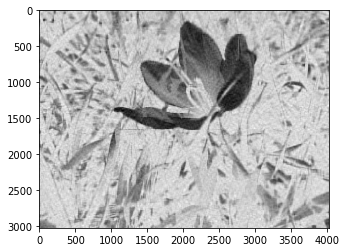

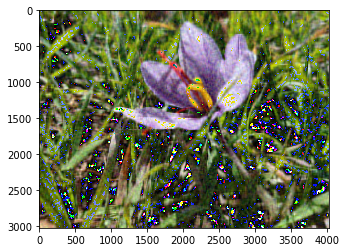

In [25]:
# Graficamos la imagen obtenida para uno de los canales
img=plt.imshow(A_b_k)
img.set_cmap('binary')
plt.show()

# Componemos los canales en una nueva imagen y graficamos
A_rgb_k = np.zeros(img_orig.shape, np.int32)
A_rgb_k[:, :, 0] = A_r_k.astype(np.uint8)
A_rgb_k[:, :, 1] = A_g_k.astype(np.uint8)
A_rgb_k[:, :, 2] = A_b_k.astype(np.uint8)

img=plt.imshow(A_rgb_k)
plt.show()



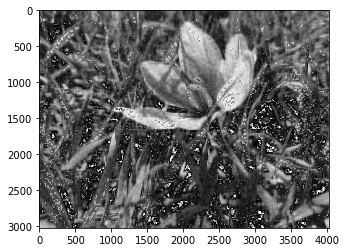

Reducción de Espacio:-0.54%
Error de truncado:32.52%


In [28]:
# Convertimos la imagen compuesta a escala de grises y promediamos intensidades
A_gray_k = np.mean(A_rgb_k, -1)
img=plt.imshow(A_gray_k)
img.set_cmap('gray')
plt.show()

# Comparamos las metricas con lo obtenido en cada canal
ss_gray_k = saved_space(file_gray, A_gray_k)
print("Reducción de Espacio:{0:.2f}%".format(ss_gray_k*100))

et_gray_k = error_truncation(A, A_gray_k)
print("Error de truncado:{0:.2f}%".format(et_gray_k*100))


In [29]:
# Se compara el valor de k necesario para obtener la reducción de espacio combinada y se compara el error
# ss_gray, k_gray = saved_space_compression(ss_gray_k, U, S, VT, file_gray)
# A_gray = compresion(k_gray, U, S, VT)
# img=plt.imshow(A_gray);
# img.set_cmap('gray');
# plt.show();

# # Comparamos las metricas 
# print("Reducción de Espacio:{0:.2f}%".format(ss_gray*100))
# print("Valor de k: {}".format(k_gray))

# et_gray = error_truncation(A, A_gray)
# print("Error de truncado:{0:.2f}%".format(et_gray*100))


## Compresión de cuadros de la imagen 

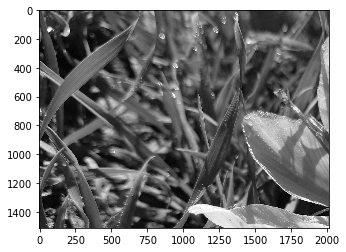

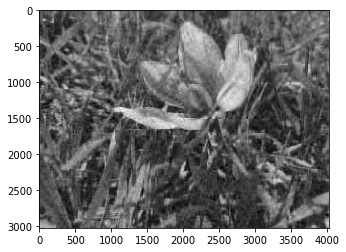

In [88]:
# Se dividira a la imagen en n cuadros
n = 4
k = 20
integer_v = int(A.shape[0]/(n/2))
remainder_v = int(A.shape[0] % (n/2))
integer_h = int(A.shape[1]/(n/2))
remainder_h = int(A.shape[1] % (n/2))
A_cuadros = np.zeros((integer_v, integer_h, n), np.int32)

# TODO: reemplazar por algoritmo en función de n
A_cuadros[:, :, 0] = A[0:integer_v, 0:integer_h]
A_cuadros[:, :, 1] = A[0:integer_v, integer_h:integer_h+integer_h]
A_cuadros[:, :, 2] = A[integer_v:integer_v+integer_v, 0:integer_h]
A_cuadros[:, :, 3] = A[integer_v:integer_v+integer_v, integer_h:integer_h+integer_h]

# Gráfica de uno de los cuadros
img=plt.imshow(A_cuadros[:, :, 0])
img.set_cmap('gray')
plt.show()

A_cuadros_k = np.zeros_like(A_cuadros)

# Almacenar métricas
ss_cuadros = []
et_cuadros = []

for i in range(A_cuadros.shape[2]):
    U_aux, S_aux, VT_aux = np.linalg.svd(A_cuadros[:, :, i])
    S_aux = np.diag(S_aux)
    A_cuadros_k[:, :, i] = compresion(k, U_aux, S_aux, VT_aux)
    file_cuadro = os.path.splitext(file)[0]+'_cuadro'+os.path.splitext(file)[1] 
    imsave(file_cuadro, A_cuadros[:, :, i], cmap="gray")
    ss_cuadros.append(saved_space(file_cuadro, A_cuadros_k[:, :, i]))
    et_cuadros.append(error_truncation(A_cuadros[:, :, i], A_cuadros_k[:, :, i]))

A_reconst = np.zeros_like(A)
A_reconst[0:integer_v, 0:integer_h] = A_cuadros_k[:, :, 0]
A_reconst[0:integer_v, integer_h:integer_h+integer_h] = A_cuadros_k[:, :, 1]
A_reconst[integer_v:integer_v+integer_v, 0:integer_h] = A_cuadros_k[:, :, 2]
A_reconst[integer_v:integer_v+integer_v, integer_h:integer_h+integer_h] = A_cuadros_k[:, :, 3]

# Gráfica imagen reconstruida
img=plt.imshow(A_reconst)
img.set_cmap('gray')
plt.show()

In [89]:
# Metricas 
print("Espacio reducido en cada cuadro [1-n]:{}".format(ss_cuadros))
print("Error de truncado en cada cuadro [1-n]:{}".format(et_cuadros))
print("\n")
# Metricas de la imagen reconstruida
ss_reconst = saved_space(file_gray, A_reconst)
et_reconst = error_truncation(A, A_reconst)
print("Espacio reducido imagen reconstruida:{}".format(ss_reconst))
print("Error de truncado imagen reconstruida:{}".format(et_reconst))
print("\n")
# Reducción de rango de imagen en grises original con mismo k
A_k = compresion(k, U, S, VT)
ss_orig = saved_space(file_gray, A_k)
et_orig = error_truncation(A, A_k)
print("Espacio reducido imagen original:{}".format(ss_orig))
print("Error de truncado imagen original:{}".format(et_orig))

Espacio reducido en cada cuadro [1-n]:[42.8099857002567, 42.17053567755375, 41.24648107064604, 35.250825723722556]
Error de truncado en cada cuadro [1-n]:[0.18832250644168427, 0.1290441973211012, 0.22103515567899462, 0.2365327578385696]


Espacio reducido imagen reconstruida:42.67197572449039
Error de truncado imagen reconstruida:0.18551892161576475


Espacio reducido imagen original:51.240816830245656
Error de truncado imagen original:0.26096638707673236
